## Imports

In [83]:
import os

import spacy
import random
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from spacy.training.example import Example

In [84]:
TRAIN_DATA_PATH = os.path.abspath("../../data/datasets/ner-swiss-receipts.json")  # Path to your training data file
TEST_DATA_PATH = os.path.abspath("../../data/datasets/ner-swiss-receipts.json")  # Path to your testing data file
OUTPUT_DIR = os.path.abspath("../models/receipts-ner-v02")  # TODO: make sure to use a new version
ITERATIONS = 30  # Number of training iterations
BATCH_SIZE = 8  # Batch size for training
DROPOUT = 0.5  # Dropout rate

## Preprocessing

### Load Dataset

In [106]:
with open(TRAIN_DATA_PATH, "r", encoding="utf-8") as file:
    train_dataset = json.load(file)

### Reformat for Spacy & Remove unwanted Entities

In [107]:
train_data = []
for entry in train_dataset:
    text = entry["text"]
    entities = [entity for entity in entry["entities"] if entity[2] == 'RECEIPT_ITEM']
    train_data.append((text, {"entities": entities}))

In [108]:
print("Sample Training Data:")
sample_text, sample_annotaiton = train_data[0]
print("-----------------------------------------")
print(sample_text)
print("-----------------------------------------")
for ent in sample_annotaiton.get("entities"):
    print(f'Entity-Type: {ent[2]}, Entity text: {sample_text[ent[0]:ent[1]]}')

Sample Training Data:
-----------------------------------------
HAMNUGLU GmbH
HERTENSTEIN

Hertensteinstrasse 32

6004 Luzern

Tel 041 419 71 51
RER

#CS0 Rechnungsnummer: 36 POSEJ Order: el
KASSE 32- 2071272024 14:23:55

ANZ ARTIKEL GESAMT "
1MeChicken 6.90 M
ı MM 9 McNuggets f 15.800. Ep
19 Nucpets 2
1 Cocktail Sauce

. 1 Potatoes Sauce
1 Hen ohne Ksäure 0.5 2
1 Medium Pommes Frite ed
1 Cocktail Sauce en

Subtotal 2.10 u
Discount: i -1.30 Be
INNEN TOTAL 21.40 wo
VISA 210 0

st.Nr. CHE - 449.055.085 MWST ] 0
SATZ BRUTTO MWST.
incl. MWST  8.10 21.40 1.60

 Kundenbeleg

Buchung
. Visa payWave contact less

4323 22XX XXXX 1361

20.12.2024 14:23:41
u Trm-Id: 10138349
AID: 40000000031010
Irx. Seg-Cnt: Mo

..... Trx. Ref-No: .

Auth, Code:

-----------------------------------------
Entity-Type: RECEIPT_ITEM, Entity text: 1MeChicken 6.90 M
Entity-Type: RECEIPT_ITEM, Entity text: ı MM 9 McNuggets f 15.800. Ep


## Model Definition

Load an emtpy spacy model for specific language

In [90]:
# For a blank model, or replace with spacy.load("en_core_web_sm")
nlp = spacy.blank("de")

### Add Named-Entity Recognition Component

In [91]:
if "ner" not in nlp.pipe_names:
    ner = nlp.add_pipe("ner", last=True)
else:
    ner = nlp.get_pipe("ner")

### Add Labels to Model

In [92]:
for _, annotations in train_data:
    for ent in annotations.get("entities"):
        ner.add_label(ent[2])

### Spacy Examples

In [93]:
examples = [
    Example.from_dict(nlp.make_doc(text), annotations) for text, annotations in train_data
]

/Users/timon/.pyenv/versions/3.10.16/envs/dspro/lib/python3.10/site-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "mi rolino idee MIGROL

Migrol Service
Überriauerst..." with entities "[[255, 282, 'RECEIPT_ITEM'], [283, 306, 'RECEIPT_I...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/Users/timon/.pyenv/versions/3.10.16/envs/dspro/lib/python3.10/site-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "AUS
FREUDE
AM
GESCHMACK

Macchi AG Bäckerei
Überna..." with entities "[[213, 234, 'RECEIPT_ITEM'], [235, 267, 'RECEIPT_I...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


### Training

In [94]:
# Disable other pipes during training for efficiency
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]
with nlp.disable_pipes(*other_pipes):
    optimizer = nlp.begin_training()
        
    # Training loop
    print("Starting training...")
    for epoch in range(ITERATIONS):
        random.shuffle(examples)
        losses = {}
        for batch in spacy.util.minibatch(examples, size=BATCH_SIZE):
            nlp.update(batch, drop=DROPOUT, losses=losses)
        print(f"Epoch {epoch + 1}/{ITERATIONS}, Loss: {losses['ner']:.4f}")

Starting training...
Epoch 1/30, Loss: 5432.7920
Epoch 2/30, Loss: 1511.3059
Epoch 3/30, Loss: 891.8314
Epoch 4/30, Loss: 1316.4863
Epoch 5/30, Loss: 668.6835
Epoch 6/30, Loss: 714.7592
Epoch 7/30, Loss: 652.6051
Epoch 8/30, Loss: 634.9566
Epoch 9/30, Loss: 460.3464
Epoch 10/30, Loss: 389.5119
Epoch 11/30, Loss: 339.2582
Epoch 12/30, Loss: 286.5053
Epoch 13/30, Loss: 258.8651
Epoch 14/30, Loss: 271.9643
Epoch 15/30, Loss: 233.1103
Epoch 16/30, Loss: 201.2882
Epoch 17/30, Loss: 217.1197
Epoch 18/30, Loss: 162.9045
Epoch 19/30, Loss: 166.9204
Epoch 20/30, Loss: 154.9951
Epoch 21/30, Loss: 144.8921
Epoch 22/30, Loss: 121.7285
Epoch 23/30, Loss: 101.3912
Epoch 24/30, Loss: 113.0410
Epoch 25/30, Loss: 100.0297
Epoch 26/30, Loss: 93.2699
Epoch 27/30, Loss: 79.7995
Epoch 28/30, Loss: 82.5662
Epoch 29/30, Loss: 95.2030
Epoch 30/30, Loss: 69.4287


### Save Model

In [95]:
# Save the trained model
print(f"Saving model to {OUTPUT_DIR}...")
nlp.to_disk(OUTPUT_DIR)

Saving model to /Users/timon/git/dspro1-receipt-ocr/named-entity-recognition/models/receipts-ner-v02...


## Evaluation

In [101]:
with open(TEST_DATA_PATH, "r", encoding="utf-8") as file:
    test_dataset = json.load(file)

In [102]:
test_data = []
for entry in test_dataset:
    text = entry["text"]
    entities = [entity for entity in entry["entities"] if entity[2] == 'RECEIPT_ITEM']
    test_data.append((text, {"entities": entities}))

In [103]:
def print_confusion_matrix(matrix, labels):
    """
    Prints a confusion matrix as a formatted string.

    Args:
        matrix (list of list of int): Confusion matrix as a 2D list.
        labels (list of str): Labels for the matrix.
    """
    max_label_length = max(len(label) for label in labels)
    padding = max_label_length + 2

    # Print header
    header = " " * padding + " ".join(f"{label:>{padding}}" for label in labels)
    print(f'{"":<15} Predicted Values')
    print(header)

    # Print each row
    for label, row in zip(labels, matrix):
        row_str = " ".join(f"{cell:>{padding}}" for cell in row)
        print(f"{label:>{padding}} {row_str}")

In [104]:
true_positive = []
false_positive = []
false_negative = []

index = 0

for text, annotations in test_data:
    # Process the text
    doc = nlp(text)
    
    # Prepare expected values (y)
    expected_entities = []
    for ent in annotations.get("entities"):    
        if ent[2] == 'RECEIPT_ITEM':
            expected_entities.append(text[ent[0]:ent[1]])

    # Print recognized entities
    for ent in doc.ents:
        if ent.text in expected_entities:
            true_positive.append(ent.text)
            expected_entities.remove(ent.text)
        else:
            false_positive.append(ent.text)
            
    false_negative.extend(expected_entities)
    
# Example usage
labels = ["Entity", "No Entity"]
confusion_matrix = [
    [len(true_positive), len(false_negative)],
    [len(false_positive), 0],
]

print('Confusion Matrix:')
print_confusion_matrix(confusion_matrix, labels)

print('\nPerformance Measures:')
precision = len(true_positive) / (len(true_positive) + len(false_positive))
recall = len(true_positive) / (len(true_positive) + len(false_negative))
f1_score = 2 * precision * recall / (precision + recall)
print('Precision: ' + str(precision))
print('Recall: ' + str(recall))
print('F1 Score: ' + str(f1_score))

# True-Positive = correct idetified entities
# false_positive = actual entity that was not identified
# False-negative = identified entity that is actually not a entity

Confusion Matrix:
                Predicted Values
                Entity   No Entity
     Entity          59           4
  No Entity           6           0

Performance Measures:
Precision: 0.9076923076923077
Recall: 0.9365079365079365
F1 Score: 0.9218749999999999


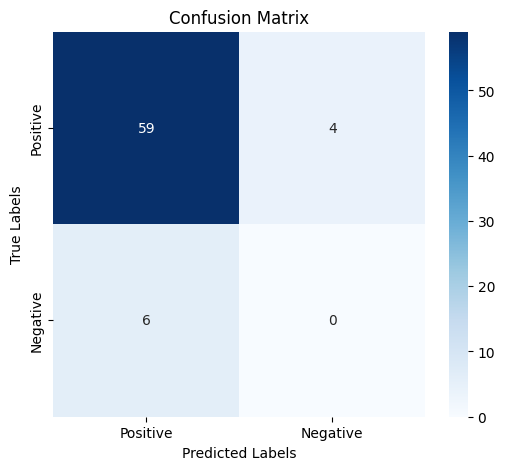

In [105]:
labels = ['Positive', 'Negative']
plt.figure(figsize=(6, 5))
sns.heatmap(
    confusion_matrix, 
    annot=True, 
    fmt="d", 
    cmap="Blues", 
    xticklabels=labels, 
    yticklabels=labels
)

# Add axis labels and title
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

